In [177]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#import ROOT as r
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

Populating the interactive namespace from numpy and matplotlib


### Load data set

In [178]:
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = np.load("newoutputs/xlowO.npy")
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")
smoothParams = np.load("newoutputs/smooth3parameters.npy")

xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

### Function to draw correlation matrix, log of covaraince matrix, and covariance matrix. Draw correlation and covariance matrix as a function of mjj

In [179]:
def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")

def plot_cor(X, C, stationary=True):
    #K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    fig = plt.figure(figsize=(6,5))
    m = plt.imshow(C, cmap="bwr",
                   interpolation='none',
                   #vmin=-1, vmax=1,
                   aspect='auto',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    cbar = plt.colorbar(m)
    m.set_clim(vmin=-1, vmax=1)
    cbar.ax.tick_params(labelsize=20) 
    plt.title("Correlation Matrix", fontsize=20)
    plt.xlabel("Mass [TeV]", fontsize=20)
    plt.ylabel("Mass [TeV]", fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    labels = ["2","3","4","5","6","7"]
    plt.xticks([2000, 3000, 4000, 5000, 6000, 7000], labels)
    plt.yticks([2000, 3000, 4000, 5000, 6000, 7000], labels)
    
def plot_individualCov(C, K):
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    for i in range(len(K[1])):
        ax1.plot(xvalO,(K[i,:]))
    ax1.semilogy()
    ax1.set_title("Covariance vs mjj")
    
    ax2 = fig.add_subplot(132)
    #ax2.semilogy()
    for i in range(len(C[1])):
        plt.plot(xvalO,C[i,:])
    ax2.set_title("Correlation vs mjj")
    
    ax3 = fig.add_subplot(133)
    ax3.plot(xvalO,(K[5,:]), c='r', label="Covariance for bin 5")
    ax3.plot(xvalO,(K[40,:]), c='g', label="Covariance for bin 40")
    ax3.plot(xvalO,(K[75,:]),c='b', label = "Covariance for bin 75")
    ax3.legend()
    ax3.semilogy()

### Function to draw fit overlaid on data on top panel, residuals on bottom panel

In [180]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])
  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  
    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



### Draw multiple fits over data

In [181]:
def makePrettyPlots_bkgFits(xs, ys, bkgFits, title, ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="3 param only fit")
        else:
            bkgPlot =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### 3 parameter fit function

In [182]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  

### Extend bins to lower values for convolution

In [183]:
#xvalO_low = np.array([794., 820.5,847.5, 875., 903., 931.5, 961.,991.,1021.5, 1052.5, 1084.0])
#xerrO_low = np.array([26., 27., 27., 28., 28., 29., 30., 30., 31.0,31.0, 32.0])
#xlowO_low = np.array([781.0, 807.0, 834.0, 861.0, 889.0, 917.0, 946.0, 976.0, 1006.0, 1037.0, 1068.0])
xvalO_low = np.array([820.5,847.5, 875., 903., 931.5, 961.,991.,1021.5, 1052.5, 1084.0])
xerrO_low = np.array([27., 27., 28., 28., 29., 30., 30., 31.0,31.0, 32.0])
xlowO_low = np.array([807.0, 834.0, 861.0, 889.0, 917.0, 946.0, 976.0, 1006.0, 1037.0, 1068.0])
nx = np.append(xvalO_low, xvalO)
nxe = np.append(xerrO_low, xerrO)
nxl = np.append(xlowO_low, xlowO)


### JES

In [184]:
def JES(x, a, b):
    A= 0.15 #low mass JES
    B = 0.05 #high mass JES
    return 1.+A*a*x**4. + B*b*(1.-x)

In [185]:
n_bins = 100
n_toys = 200
x = np.linspace(1000,7000,n_bins)
#true_dist = 1.E5*np.exp(-x/500.)
true_dist = model_3param(x, smoothParams, (x[1]-x[0])*np.ones(len(x)))
obs_dist = np.random.poisson(true_dist)
xs = nx
zs = x
#nx = x
#nxe = np.ones(len(xs))*(xs[1]-xs[0])
mod = true_dist
alist = np.random.randn(n_toys)
blist = np.random.randn(n_toys)

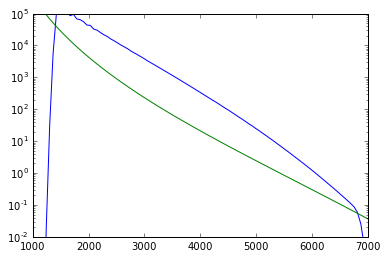

In [193]:
#zs=np.arange(nxl[0], nxl[-1], 1)
#mod = model_3param(zs, smoothParams, np.ones(len(zs)))
#xs=nx

modelMatrix_mean_m=np.zeros([n_toys, xs.size])
for bi in range(n_toys):
    #print bi
    a = alist[bi]#np.random.randn(1)
    b = blist[bi]#np.random.randn(1)
    
    gaus = ss.norm.pdf(xs.reshape(xs.shape[0],-1), zs*JES(zs/max(zs), a, b), 0.02*zs)

    t = gaus*mod
    newycounts = np.sum(t, axis=1)
    newycounts = newycounts*nxe

    modelMatrix_mean_m[bi,:]= newycounts 
    #if bi%10==0:
    #    print a, b
    #    print modelMatrix_mean_m[bi,:]

plt.plot(x, modelMatrix_mean_m[0,:])
plt.plot(x, true_dist)
plt.ylim(1E-2,1E5)
plt.yscale('log')

### Kyle's version

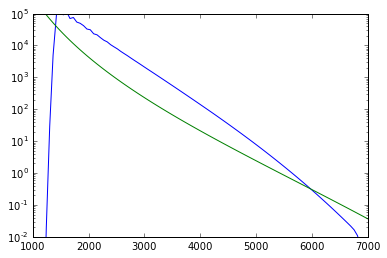

In [192]:
modelMatrix_mean=np.zeros([n_toys, n_bins])

#New JES calculation
for bi in range(n_toys):
    #print bi
    a =alist[bi]#np.random.randn(1)
    b = blist[bi]#np.random.randn(1)

    #In original code, I think xs and zs were basically the same
    binwidth = xs[1]-xs[0]
    #we need a double loop.
    # here is a half pythonic way of doing it.
    # we will loop over the z values and apply the JES smearing to the entire x axis
    newycounts = np.zeros(n_bins)
    for i, zi in enumerate(zs):
        gaus = ss.norm.pdf(xs, zi*JES(zi/max(zs), a, b), 0.02*zi)
        newycounts = newycounts + mod[i]*gaus

    newycounts = newycounts * binwidth
    modelMatrix_mean[bi,:]= newycounts
    #if bi%10==0:
    #    print a, b
    #    print modelMatrix_mean[bi,:]
    
plt.plot(x, modelMatrix_mean[0,:])
plt.plot(x, true_dist)
plt.ylim(1E-2,1E5)
plt.yscale('log')

In [188]:
print modelMatrix_mean
print modelMatrix_mean_m

[[  9.79004699e-23   1.46194013e-16   4.36301640e-11 ...,   4.66544627e-03
    9.40213942e-04   7.15825851e-05]
 [  4.43725761e-12   2.39432063e-07   2.42804812e-03 ...,   4.18923432e-08
    1.59164777e-10   1.81172632e-13]
 [  1.65591425e-24   4.01118793e-18   1.95934623e-12 ...,   1.12702052e-02
    5.45290085e-03   1.28534411e-03]
 ..., 
 [  2.55063295e-07   2.19886099e-03   3.44353619e+00 ...,   2.53619609e-02
    2.12365498e-02   1.77870234e-02]
 [  2.42581012e-12   1.43630477e-07   1.60099666e-03 ...,   7.10646235e-03
    2.14548366e-03   2.64698665e-04]
 [  2.78610834e-36   1.22198946e-28   1.14033685e-21 ...,   4.88978277e-17
    6.33595164e-21   2.29899891e-25]]
[[  9.79004699e-23   1.46194013e-16   4.52460960e-11 ...,   2.52279687e-02
    5.15376531e-03   4.00332235e-04]
 [  4.43725761e-12   2.39432063e-07   2.51797583e-03 ...,   2.26528967e-07
    8.72458778e-10   1.01322472e-12]
 [  1.65591425e-24   4.01118793e-18   2.03191461e-12 ...,   6.09425909e-02
    2.98899750e-02   

In [189]:
covMat_mean = np.cov(modelMatrix_mean[:,11:].T)
corMat_mean = np.corrcoef(modelMatrix_mean[:,11:].T)
covMat_mean_m = np.cov(modelMatrix_mean_m[:,11:].T)
corMat_mean_m = np.corrcoef(modelMatrix_mean_m[:,11:].T)

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log


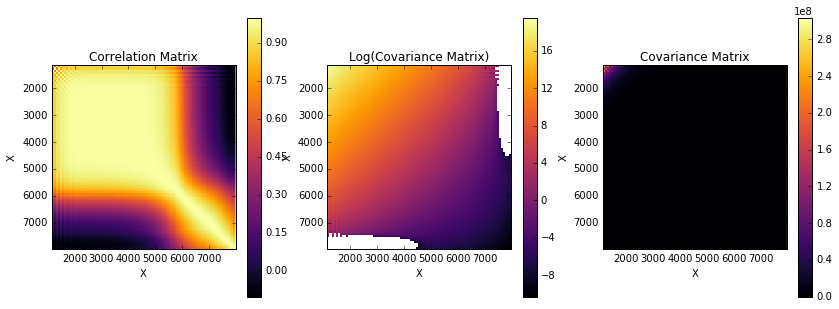

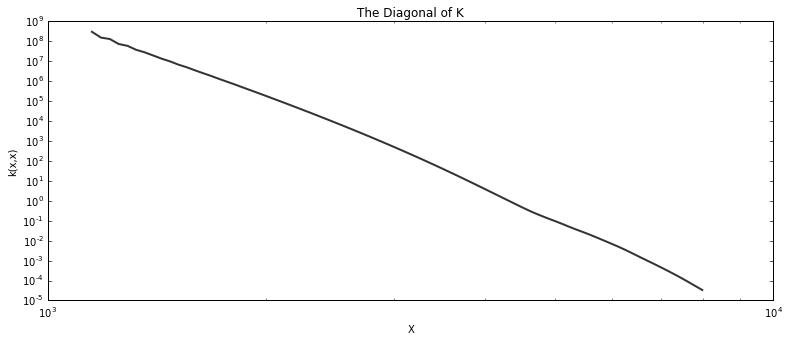

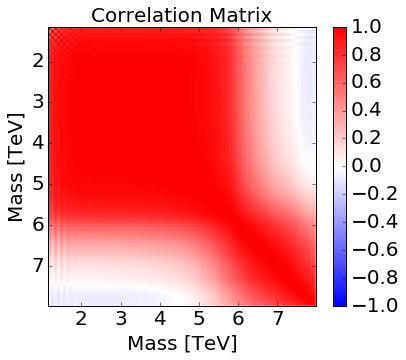

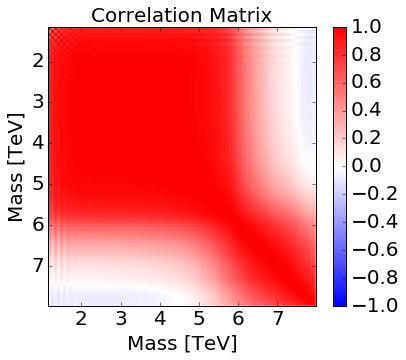

In [190]:
plot_cov(nx[11:].reshape(-1,1), corMat_mean, covMat_mean, False)
plot_cor(nx[11:].reshape(-1,1), corMat_mean, False)
plot_cor(nx[11:].reshape(-1,1), corMat_mean_m, False)

makePrettyPlots_bkgFits(nx[11:], yvalO, (modelMatrix_mean[:,11:]).tolist(), "", ymax = 2e5)

ValueError: x and y must have same first dimension

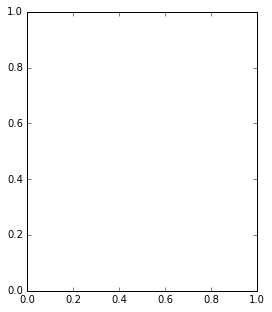

In [191]:
plot_individualCov(corMat_mean, covMat_mean)